In [128]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use('default')
import seaborn as sns 
sns.set()

In [129]:
data=pd.read_csv("prod_commandes_expeditions_retours_stocks.csv" , encoding="utf-8")

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42458 entries, 0 to 42457
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_commande      42458 non-null  object 
 1   date_commande    42458 non-null  object 
 2   id_produit       42458 non-null  object 
 3   quantité_x       42458 non-null  int64  
 4   entrepôt_x       42458 non-null  object 
 5   statut           42458 non-null  object 
 6   id_expedition    42458 non-null  object 
 7   quantité_y       42458 non-null  float64
 8   entrepôt_y       42458 non-null  object 
 9   date_expedition  42458 non-null  object 
 10  date_livraison   42458 non-null  object 
 11  transporteur     42458 non-null  object 
 12  coût_transport   42458 non-null  float64
 13  délai_livraison  42458 non-null  float64
 14  mois_x           42458 non-null  object 
 15  date_retour      2987 non-null   object 
 16  motif            2987 non-null   object 
 17  mois_y      

In [131]:
data.rename(columns={
    'quantité_x': 'quantité_commandée',
    'quantité_y': 'quantité_expediée',
    'entrepôt_x': 'entrepot_commande',
    'entrepôt_y': 'entrepot_expedition',
    'mois_x': 'mois_commande',
    'mois_y': 'mois_retour'
}, inplace=True)


In [132]:
data.isnull().sum()

id_commande                0
date_commande              0
id_produit                 0
quantité_commandée         0
entrepot_commande          0
statut                     0
id_expedition              0
quantité_expediée          0
entrepot_expedition        0
date_expedition            0
date_livraison             0
transporteur               0
coût_transport             0
délai_livraison            0
mois_commande              0
date_retour            39471
motif                  39471
mois_retour            39471
catégorie                  0
marque                     0
prix                       0
stock_minimum              0
niveau_stock               0
entrepot                   0
dtype: int64

## 📌 Analyse des valeurs manquantes

Lors de l’analyse des données, on observe que trois colonnes présentent environ **93 % de valeurs manquantes** :

- `date_retour`
- `motif`
- `mois_retour`

Ces colonnes sont toutes liées à la **gestion des retours**.

🎯 **Explication :**  
La grande majorité des commandes **n’ont pas été retournées**, ce qui est logique dans un processus de vente classique.  
Ainsi, les champs relatifs au retour (date, motif, mois) restent **vides** pour ces commandes.

✅ **Conclusion :**  
Ces valeurs manquantes ne sont pas des erreurs, mais reflètent simplement le fait que **seules une minorité de commandes (environ 7 %) ont donné lieu à un retour produit**.  
On pourra donc traiter ces champs avec prudence lors des analyses (ex. : filtrer uniquement les lignes avec retour quand nécessaire).


In [133]:

# ✅ Objectif : traiter les colonnes liées aux retours

# 1. Créer une copie du DataFrame original
data_ml = data.copy()

# 2. Créer une colonne binaire "retour" :
#    - 1 si la commande a été retournée (date_retour non nulle)
#    - 0 sinon
data_ml['retour'] = data_ml['date_retour'].notnull().astype(int)

# 3. Remplacer les valeurs manquantes :
#    - 'motif' ➜ "Aucun"
#    - 'mois_retour' ➜ "Non retourné"
data_ml['motif'] = data_ml['motif'].fillna("Aucun")
data_ml['mois_retour'] = data_ml['mois_retour'].fillna("Non retourné")

# 4. Supprimer la colonne "date_retour" (non numérique, peu utile pour modélisation)
data_ml.drop(columns=['date_retour'], inplace=True)

# 5. Vérification du résultat sur les premières lignes
data_ml[['retour', 'motif', 'mois_retour']].head()


,retour,motif,mois_retour
0,0,Aucun,Non retourné
1,0,Aucun,Non retourné
2,0,Aucun,Non retourné
3,0,Aucun,Non retourné
4,0,Aucun,Non retourné


# 📌 Étape : Traitement des doublons

# ✅ Objectif : 
# 1. Supprimer les doublons exacts (toutes les colonnes identiques)
# 2. Analyser les doublons sur "id_commande" (car ils peuvent être légitimes)

In [134]:
# Compter le nombre de doublons exacts avant suppression
doublons_complets_avant = data_ml.duplicated().sum()
print(f"Nombre de doublons exacts avant suppression : {doublons_complets_avant}")

Nombre de doublons exacts avant suppression : 10


In [135]:
# Suppression des doublons exacts
data_ml = data_ml.drop_duplicates()
# Vérification après suppression
doublons_complets_apres = data_ml.duplicated().sum()
print(f"Nombre de doublons exacts après suppression : {doublons_complets_apres}")

Nombre de doublons exacts après suppression : 0


In [136]:
# 2️⃣ Analyse des doublons sur "id_commande"

# Compter combien de fois chaque id_commande apparaît
id_commande_counts = data_ml['id_commande'].value_counts()
id_commande_counts


id_commande
O004604    2
O013436    2
O022538    2
O007862    2
O005752    2
          ..
O049996    1
O049997    1
O049998    1
O049999    1
O050000    1
Name: count, Length: 42404, dtype: int64

In [137]:
# Filtrer les id_commande qui apparaissent plus d'une fois
id_commande_en_double = id_commande_counts[id_commande_counts > 1]

print(f"\nNombre d'id_commande apparaissant plusieurs fois : {len(id_commande_en_double)}")


Nombre d'id_commande apparaissant plusieurs fois : 44


In [138]:
# Afficher un exemple de lignes concernées
exemples_doublons_id = data_ml[data_ml['id_commande'].isin(id_commande_en_double.index)].sort_values('id_commande')

# Afficher les premières lignes concernées
exemples_doublons_id.head(10)

,id_commande,date_commande,id_produit,quantité_commandée,entrepot_commande,statut,id_expedition,quantité_expediée,entrepot_expedition,date_expedition,...,mois_commande,motif,mois_retour,catégorie,marque,prix,stock_minimum,niveau_stock,entrepot,retour
2264,O002660,2024-09-13,P00029,5,Marseille,Livré,SHP002265,5.0,Marseille,2024-09-19,...,2024-09,Client insatisfait,2024-10,Soins capillaires,Reflet d'or,277.95,82,268,Paris,1
2265,O002660,2024-09-13,P00029,5,Marseille,Livré,SHP002265,5.0,Marseille,2024-09-19,...,2024-09,Client insatisfait,2024-09,Soins capillaires,Reflet d'or,277.95,82,268,Paris,1
3563,O004182,2024-12-07,P00921,10,Paris,Livré,SHP003562,10.0,Paris,2024-12-14,...,2024-12,Mauvaise référence,2025-01,Maquillage,Aura Cristal,47.73,10,11,Marseille,1
3564,O004182,2024-12-07,P00921,10,Paris,Livré,SHP003562,10.0,Paris,2024-12-14,...,2024-12,Livraison incomplète,2024-12,Maquillage,Aura Cristal,47.73,10,11,Marseille,1
3628,O004258,2024-03-16,P00653,2,Paris,Livré,SHP003626,2.0,Paris,2024-03-23,...,2024-03,Mauvaise référence,2024-04,Maquillage,Silhouette Paris,473.41,60,101,Paris,1
3629,O004258,2024-03-16,P00653,2,Paris,Livré,SHP003626,2.0,Paris,2024-03-23,...,2024-03,Mauvaise référence,2024-03,Maquillage,Silhouette Paris,473.41,60,101,Paris,1
3635,O004264,2024-02-05,P00986,1,Marseille,Livré,SHP003632,1.0,Marseille,2024-02-11,...,2024-02,Livraison incomplète,2024-02,Maquillage,Cosmétika,452.85,90,78,Lyon,1
3636,O004264,2024-02-05,P00986,1,Marseille,Livré,SHP003632,1.0,Marseille,2024-02-11,...,2024-02,Livraison incomplète,2024-03,Maquillage,Cosmétika,452.85,90,78,Lyon,1
3919,O004604,2024-02-23,P00831,15,Marseille,Livré,SHP003915,15.0,Marseille,2024-02-29,...,2024-02,Client insatisfait,2024-03,Soins capillaires,Maison Vitalis,116.45,66,17,Lyon,1
3920,O004604,2024-02-23,P00831,15,Marseille,Livré,SHP003915,15.0,Marseille,2024-02-29,...,2024-02,Client insatisfait,2024-02,Soins capillaires,Maison Vitalis,116.45,66,17,Lyon,1


## 📌 Gestion des doublons

### 1️⃣ Suppression des doublons exacts

Lors de l'analyse, nous avons détecté **10 doublons exacts** dans l'ensemble du dataset.  
Ces doublons représentaient des lignes strictement identiques sur **toutes les colonnes**.

🎯 **Action :**  
Nous avons supprimé ces 10 doublons pour éviter de biaiser les statistiques ou les modèles futurs.

---

### 2️⃣ Analyse des doublons sur `id_commande`

Après suppression des doublons exacts, nous avons observé que **44 identifiants de commande (`id_commande`)** apparaissaient encore plusieurs fois.

🔎 **Observation détaillée :**
- En examinant les lignes associées à ces `id_commande`, nous avons constaté qu'elles étaient **totalement identiques** (même produit, même quantité, même entrepôt, etc.).
- Cela indique que ces doublons sont probablement dus à des **erreurs de saisie ou de fusion des données**.
- Ce ne sont **pas** des cas normaux de commandes multi-produits.

🎯 **Action :**  
Nous allons donc **supprimer les doublons** sur `id_commande` en ne gardant qu'une seule occurrence par commande.

---


In [139]:
# 📌 Étape : Suppression des doublons sur id_commande

# ✅ Objectif : Ne conserver qu'une seule ligne par "id_commande" pour éviter les répétitions injustifiées

# Suppression en gardant la première occurrence de chaque id_commande
data_ml = data_ml.drop_duplicates(subset=['id_commande'], keep='first')

# Vérification : il ne doit plus y avoir de doublons sur id_commande
doublons_id_commande_apres = data_ml['id_commande'].duplicated().sum()
print(f"Nombre de doublons sur id_commande après suppression : {doublons_id_commande_apres}")


Nombre de doublons sur id_commande après suppression : 0


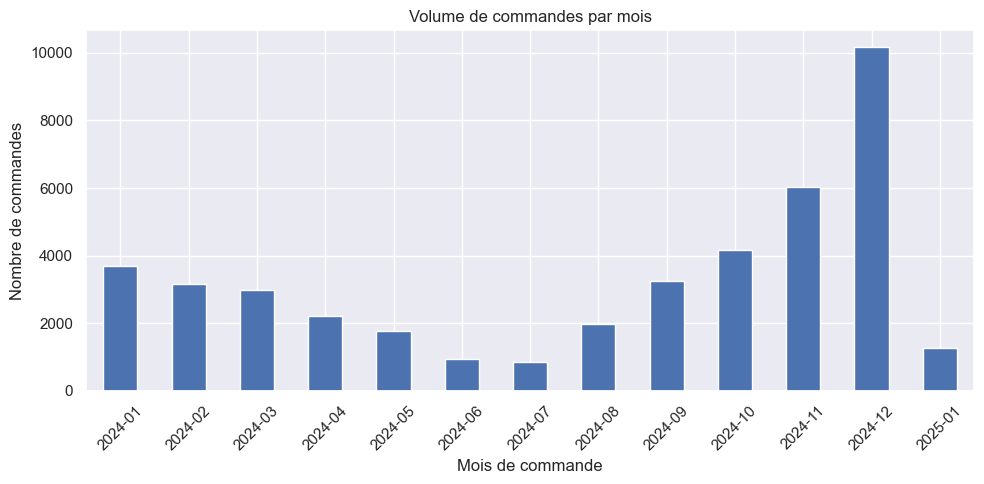

In [140]:
# 📌 Visualisation 1 : Volume de commandes par mois (Barplot)

# ✅ Objectif : Détecter la saisonnalité des commandes
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
data_ml['mois_commande'].value_counts().sort_index().plot(kind='bar')
plt.title('Volume de commandes par mois')
plt.xlabel('Mois de commande')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📊 Volume de commandes par mois

Ce graphique met en évidence une **saisonnalité marquée** dans le comportement des clients.

### 🔎 Observations principales :

- Les mois de **novembre** et surtout **décembre** affichent le **plus grand volume de commandes**. Cela correspond très probablement à la période des **fêtes de fin d'année** (Black Friday, Noël), où les achats augmentent fortement.
- À l'inverse, les mois de **juin** et **juillet** présentent une baisse significative, possiblement liée aux **vacances d'été**, où les clients consomment moins, notamment pour les produits non essentiels.
- Le mois de **janvier** est aussi relativement élevé, ce qui peut s'expliquer par les **soldes d’hiver** ou les **achats post-fêtes** (cartes cadeaux, échanges, etc.).

### 📈 Autres éléments à noter :

- On observe une **forme en U** : l’activité commence haut en début d’année, chute au milieu, puis remonte en fin d’année.
- Dès **août et surtout septembre**, on note une reprise progressive du volume, probablement liée à la **rentrée**.
- Cette tendance confirme une forte **dépendance du cycle de vente à la saison** et aux événements commerciaux majeurs.

✅ **Conclusion** : L’entreprise connaît des pics de commandes bien définis à certaines périodes de l’année. Cela peut guider les décisions en matière de marketing, de logistique et de gestion des stocks.


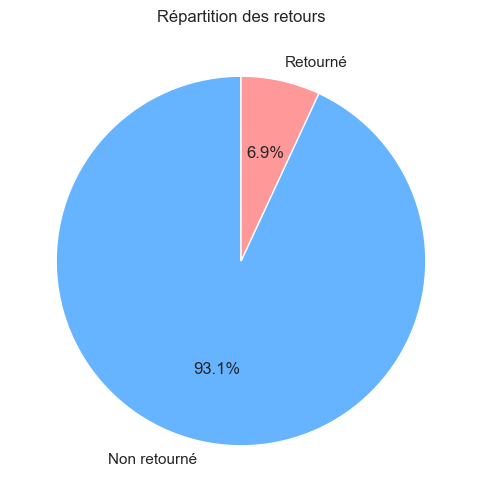

In [141]:
# 📌 Visualisation 2 : Répartition des retours vs non-retours (Pie Chart)

# ✅ Objectif : Visualiser la part des commandes retournées (satisfaction client)

retour_counts = data_ml['retour'].value_counts()
labels = ['Non retourné', 'Retourné']

plt.figure(figsize=(6,6))
plt.pie(retour_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#ff9999'])
plt.title('Répartition des retours')
plt.show()


## 📊 Répartition des retours

Le graphique montre que **93,1 % des commandes n’ont pas été retournées**, contre seulement **6,9 % de retours**.

### ✅ Interprétation :

- Ce taux de retour relativement faible est généralement considéré comme un **bon indicateur de performance**, notamment dans le secteur du e-commerce.
- Il suggère que les **produits sont conformes aux attentes**, bien décrits, correctement emballés et livrés dans de bonnes conditions.
- Cela peut aussi traduire une **bonne gestion de la relation client** (information claire, politique de retour fluide, etc.).

### 🔍 Pour aller plus loin :

- Il serait utile d'examiner la **répartition des retours par catégorie de produit** ou par **motif**, afin de détecter d’éventuels axes d’amélioration ciblés.

✅ **Conclusion** : Ce taux de non-retour élevé constitue un bon signal sur la **fiabilité et la qualité de l’offre proposée par l’entreprise**.


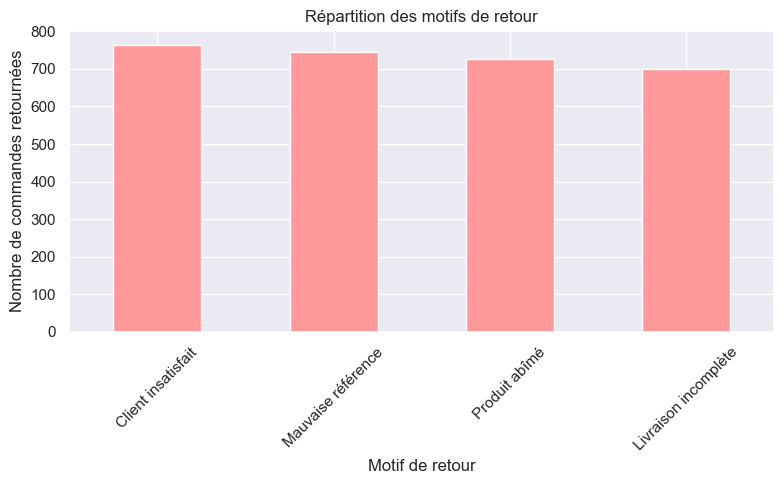

In [142]:
# 📌 Visualisation complémentaire : Répartition des motifs de retour (Barplot)

# ✅ Objectif : Comprendre pourquoi les clients retournent leurs produits

import matplotlib.pyplot as plt

# On filtre uniquement les lignes où un retour a été effectué
# Puis on compte les occurrences de chaque motif
plt.figure(figsize=(8,5))
data_ml[data_ml['retour'] == 1]['motif'].value_counts().plot(
    kind='bar',
    color='#FF9999'  # Couleur douce pour visuel agréable
)

plt.title("Répartition des motifs de retour")
plt.xlabel("Motif de retour")
plt.ylabel("Nombre de commandes retournées")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📊 Répartition des motifs de retour

Le graphique montre que les retours sont répartis entre plusieurs causes, avec des volumes relativement proches.

### 🔎 Observations principales :

- Le motif le plus fréquent est **"Client insatisfait"**, ce qui reflète une insatisfaction globale sans détail précis. Cela peut concerner la qualité perçue, l’expérience client ou un manque d’alignement entre la promesse du produit et sa réalité.
- Suivent de près :
  - **"Mauvaise référence"** ➔ probablement lié à des erreurs de préparation de commande ou à des fiches produit confuses.
  - **"Produit abîmé"** ➔ problème de transport ou de conditionnement.
- Enfin, le motif **"Livraison incomplète"** reste significatif et peut indiquer une faiblesse dans la chaîne logistique.

### 📌 Recommandations :

- Il serait judicieux d’examiner de plus près les catégories ou les entrepôts associés à ces retours afin de cibler les axes d’amélioration.
- Une enquête client ciblée sur les retours pour "insatisfaction" permettrait de mieux comprendre les causes réelles.

✅ **Conclusion** : Même si le taux global de retour est faible, une analyse fine des motifs permet d’identifier des pistes concrètes pour **renforcer la qualité de service et la satisfaction client**.


C:\Users\glenn\AppData\Local\Temp\ipykernel_26860\1138752891.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


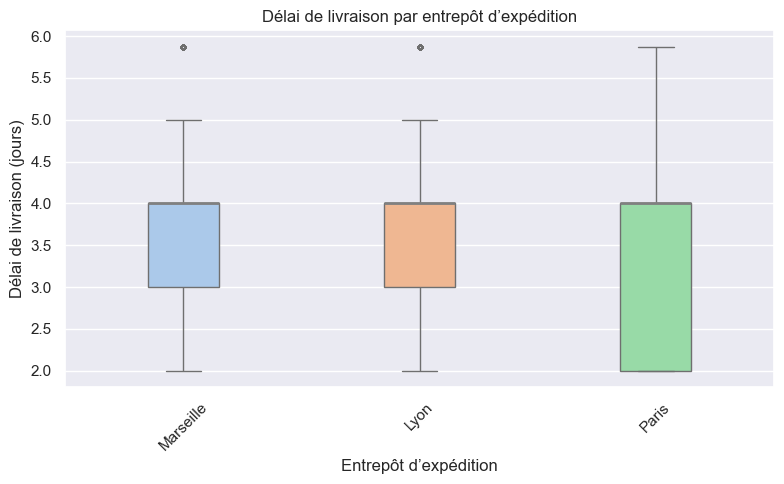

In [143]:
# 📌 Visualisation 3 : Délai de livraison par entrepôt (Boxplot)

plt.figure(figsize=(8,5))


# Utilisation de seaborn pour un boxplot propre
sns.boxplot(
    x='entrepot_expedition',
    y='délai_livraison',
    data=data_ml,
    medianprops=dict(color='grey', linewidth=2),  # Trait médiane grise
    palette='pastel',         # couleurs pastel
    width=0.3,                # largeur des boîtes
    fliersize=3               # taille des outliers (points)
)

plt.title('Délai de livraison par entrepôt d’expédition')
plt.xlabel('Entrepôt d’expédition')
plt.ylabel('Délai de livraison (jours)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📊 Délai de livraison par entrepôt d’expédition

Ce boxplot permet de visualiser la régularité des délais de livraison selon l’entrepôt d’expédition.

### 🔎 Observations :

- Les trois entrepôts présentent des délais de livraison **très similaires**, généralement compris entre **2 et 5 jours**, ce qui témoigne d’une **logistique homogène et bien maîtrisée**.
- On note **très peu de valeurs aberrantes**, ce qui confirme la **stabilité du processus logistique**.
- La **médiane** est difficile à distinguer car elle est souvent **confondue avec l’un des bords de la boîte**, ce qui reflète une **faible dispersion** autour de la valeur centrale.
- L’entrepôt de **Paris** présente une **légère dispersion plus élevée**, avec quelques livraisons atteignant presque **6 jours**. Cela peut indiquer des retards isolés à surveiller.

✅ **Conclusion** : Les performances logistiques sont globalement très bonnes et équilibrées entre les entrepôts, avec des délais courts et peu d’irrégularités.


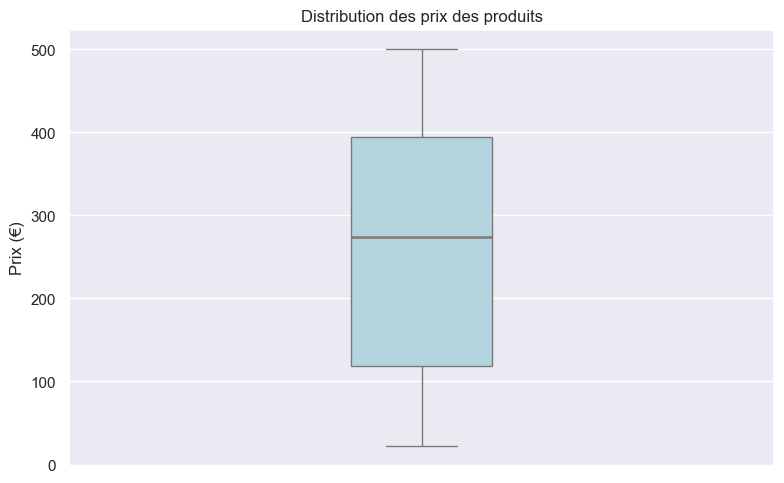

In [144]:
# 📌 Visualisation 4 : Distribution des prix des produits (Boxplot)

# ✅ Objectif : Comprendre la stratégie de prix de l'entreprise

plt.figure(figsize=(8,5))
sns.boxplot(
    y='prix',
    data=data_ml,
    color='#ADD8E6',   # Couleur de la boîte (bleu clair ici)
    width=0.2,           # largeur des boîtes
    fliersize=3 ,              # taille des outliers (points)
    medianprops=dict(color='grey', linewidth=2)  # Trait médiane grise
)
plt.title('Distribution des prix des produits')
plt.ylabel('Prix (€)')
plt.tight_layout()
plt.show()

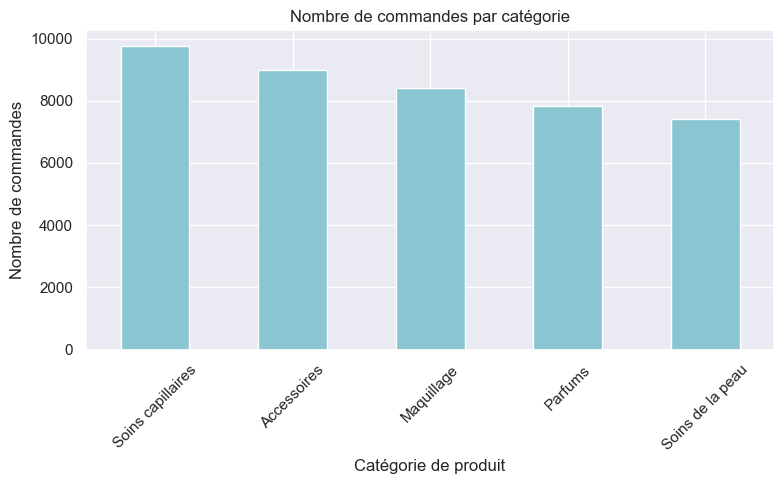

In [145]:
# 📌 Visualisation 5 : Nombre de commandes par catégorie de produit (Barplot)

# ✅ Objectif : Analyser la popularité des catégories de produits

import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
data_ml['catégorie'].value_counts().plot(kind='bar', color='#8AC6D1')
plt.title('Nombre de commandes par catégorie')
plt.xlabel('Catégorie de produit')
plt.ylabel('Nombre de commandes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📊 Nombre de commandes par catégorie de produit

Ce graphique permet d'identifier les catégories les plus populaires auprès des clients.

### 🔎 Observations :

- La catégorie **"Soins capillaires"** arrive en tête, avec le plus grand nombre de commandes. Cela peut s’expliquer par une **demande particulièrement forte**, une **gamme de produits variée** ou des **actions marketing efficaces**.
- Les **"Accessoires"** et le **"Maquillage"** suivent, ce qui indique qu’ils font partie des catégories **phare de l’entreprise**.
- Les **"Parfums"** et les **"Soins de la peau"** présentent un volume de commandes plus modéré, bien qu’important. Cela pourrait refléter une **offre plus haut de gamme**, ou des produits **achetés moins fréquemment**.

✅ **Conclusion** : Cette répartition permet d’orienter les efforts marketing, de mieux ajuster les stocks, et de renforcer les points forts de l’entreprise.


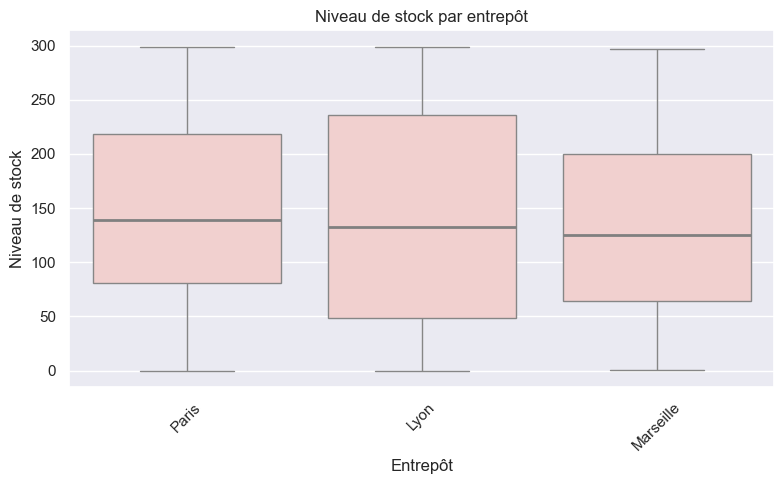

In [146]:
# 📌 Visualisation 6 : Niveau de stock par entrepôt (Boxplot)

# ✅ Objectif : Comparer la distribution du niveau de stock par entrepôt

plt.figure(figsize=(8,5))
sns.boxplot(
    x='entrepot',
    y='niveau_stock',
    data=data_ml,
    color='#F7CAC9',  # Couleur douce rose clair
    medianprops=dict(color='grey', linewidth=2)  # Trait de médiane bien visible
)

plt.title('Niveau de stock par entrepôt')
plt.xlabel('Entrepôt')
plt.ylabel('Niveau de stock')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 📊 Niveau de stock par entrepôt

Ce boxplot permet de comparer la gestion des niveaux de stock dans les différents entrepôts de l’entreprise.

### 🔎 Observations :

- Les trois entrepôts présentent une **médiane de stock relativement similaire**, autour de **130 à 150 unités**, ce qui montre une certaine cohérence globale.
- L’entrepôt de **Lyon** affiche une **plus grande dispersion** des niveaux de stock, ce qui pourrait refléter une **gestion plus variable selon les produits**.
- On observe des niveaux de stock **à zéro dans tous les entrepôts**, ce qui peut indiquer des **ruptures temporaires**, ou des produits **sortis de catalogue**.
- **Paris** et **Marseille** semblent avoir une **distribution plus stable**, avec des niveaux de stock plus concentrés.

✅ **Conclusion** : Cette analyse peut aider à **harmoniser la stratégie de stockage** entre les entrepôts, et à anticiper les risques de rupture pour certains produits.


In [147]:
# 📌 Calcul des KPIs orientés client-entreprise

# 1️⃣ Taux de retour global
# Pourcentage de commandes retournées
taux_retour = data_ml['retour'].mean() * 100

# 2️⃣ Délai moyen et médian de livraison
# Permet de mesurer la performance logistique
delai_moyen = data_ml['délai_livraison'].mean()
delai_median = data_ml['délai_livraison'].median()

# 3️⃣ Nombre moyen de produits par commande
# Supposition : une ligne = un produit d'une commande
produits_par_commande = data_ml.groupby('id_commande').size().mean()

# 4️⃣ Taux de rupture de stock
# Proportion de produits avec un niveau de stock égal à zéro
taux_rupture_stock = (data_ml['niveau_stock'] == 0).mean() * 100

# 5️⃣ Moyenne du stock disponible vs stock minimum requis
stock_moyen = data_ml['niveau_stock'].mean()
stock_minimum_moyen = data_ml['stock_minimum'].mean()

# 6️⃣ Catégorie la plus commandée et son volume
top_categorie = data_ml['catégorie'].value_counts().idxmax()
volume_top_categorie = data_ml['catégorie'].value_counts().max()

# ✅ Affichage des résultats dans un tableau structuré
import pandas as pd

kpi_results = {
    "Taux de retour (%)": round(taux_retour, 2),
    "Délai moyen de livraison (jours)": round(delai_moyen, 2),
    "Délai médian de livraison (jours)": round(delai_median, 2),
    "Nb moyen de produits par commande": round(produits_par_commande, 2),
    "Taux de rupture de stock (%)": round(taux_rupture_stock, 2),
    "Stock moyen": round(stock_moyen, 2),
    "Stock minimum moyen": round(stock_minimum_moyen, 2),
    "Catégorie la plus commandée": top_categorie,
    "Volume commandes - catégorie top": volume_top_categorie
}

# Affichage sous forme de DataFrame
pd.DataFrame(kpi_results, index=["Valeur"])


,Taux de retour (%),Délai moyen de livraison (jours),Délai médian de livraison (jours),Nb moyen de produits par commande,Taux de rupture de stock (%),Stock moyen,Stock minimum moyen,Catégorie la plus commandée,Volume commandes - catégorie top
Valeur,6.92,3.65,4.0,1.0,0.46,141.67,51.28,Soins capillaires,9772


probleme git 